# ARIMA Model for Query Rate Forecasting

Time Series Forecasting skeleton model for predicting query rates on database management systems

## Dependencies

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from numpy import log

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox

## Import Dataset

In [178]:
# Generate example dataset
startDate = '2020-01-01'
endDate = '2024-01-01'
numDays = (pd.to_datetime(endDate) - pd.to_datetime(startDate)).days + 1

# Generate dates by day
dates = pd.date_range(start = startDate, end = endDate, freq = 'D')

# Generate random query rates
np.random.seed(0)  # For reproducibility
queryRate = np.random.randint(0, 200, size = numDays)  # Random query rates between 0 and 200
#normalizedQueryRate = np.random.normal(loc=100, scale=10, size=len(dates))  # Normalized set of query data

In [180]:
# Create a DataFrame
df = pd.DataFrame({'Date': dates, 'Query Rate': queryRate})
df.set_index('Date', inplace = True)
df.head()

,Query Rate
Date,
2020-01-01,172
2020-01-02,47
2020-01-03,117
2020-01-04,192
2020-01-05,67


## Clean and Preprocess Data

### Detecting Missing Values

In [181]:
# Fill in missing values
df = df.iloc[1:]
df = df.fillna(method='ffill')

# Alternatively drop missing values
# training = training.dropna(how='all')

### Detecting Outliers

In [193]:
# Calculate Z-score
z_scores = (df - df.mean()) / df.std()
threshold = 2
outliers = df[abs(z_scores) > threshold]

print("Z-Score Outliers:")
print()
print(outliers)

Z-Score Outliers:

            Query Rate
Date                  
2020-01-02         NaN
2020-01-03         NaN
2020-01-04         NaN
2020-01-05         NaN
2020-01-06         NaN
...                ...
2023-12-28         NaN
2023-12-29         NaN
2023-12-30         NaN
2023-12-31         NaN
2024-01-01         NaN

[1461 rows x 1 columns]


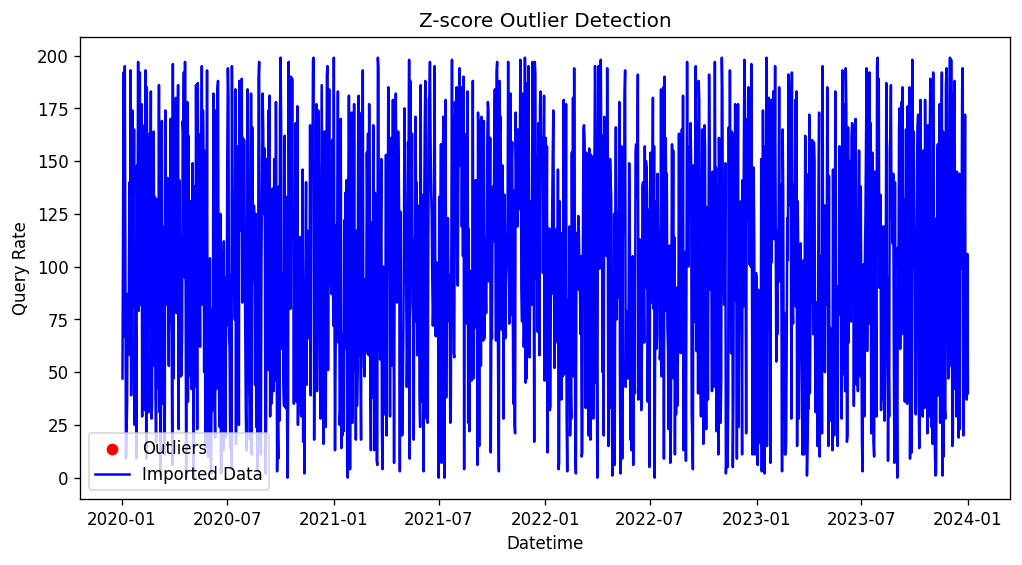

In [191]:
# Highlight outliers graphically
plt.figure(figsize=(10, 5))
plt.scatter(outliers.index, outliers.values, color='red', label='Outliers')
plt.plot(df, label='Imported Data', color='blue')

plt.title('Z-score Outlier Detection')
plt.xlabel('Datetime')
plt.ylabel('Query Rate')
plt.legend()
plt.show()

### Hypothesis Testing - Checking Significance(p) Value

In [194]:
result = adfuller(df['Query Rate'].dropna())
# Check if p-value < significance value(0.05)
print('p-value: %f' % result[1])

p-value: 0.000000


In [195]:
# Creating Date Ranges for Specific Examinations if Desired
year2020 = pd.date_range(start = '1/1/2020', end = '1/1/2021', freq = 'M')
year2021 = pd.date_range(start = '1/1/2021', end = '1/1/2022', freq = 'M')

Note: Additional action can consider resampling through either upsampling or downsampling if further or less insight is desired for a specific time frame

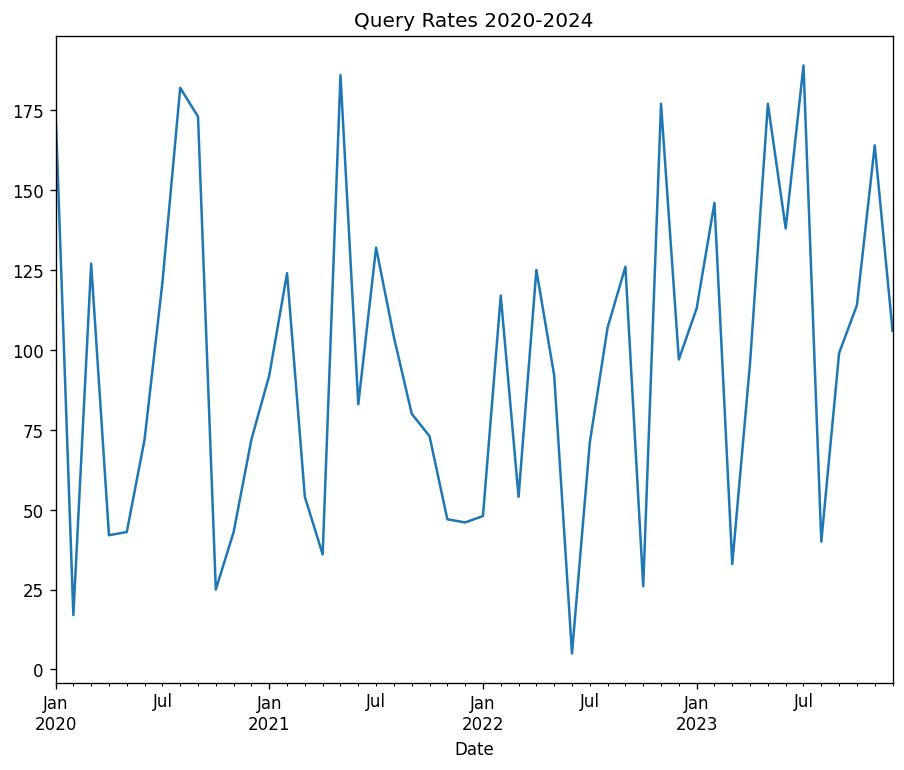

In [197]:
# Visualize Data
df['Query Rate'].asfreq('M').plot()
plt.title('Query Rates 2020-2024')
plt.show()

### Differencing for Stationary Data

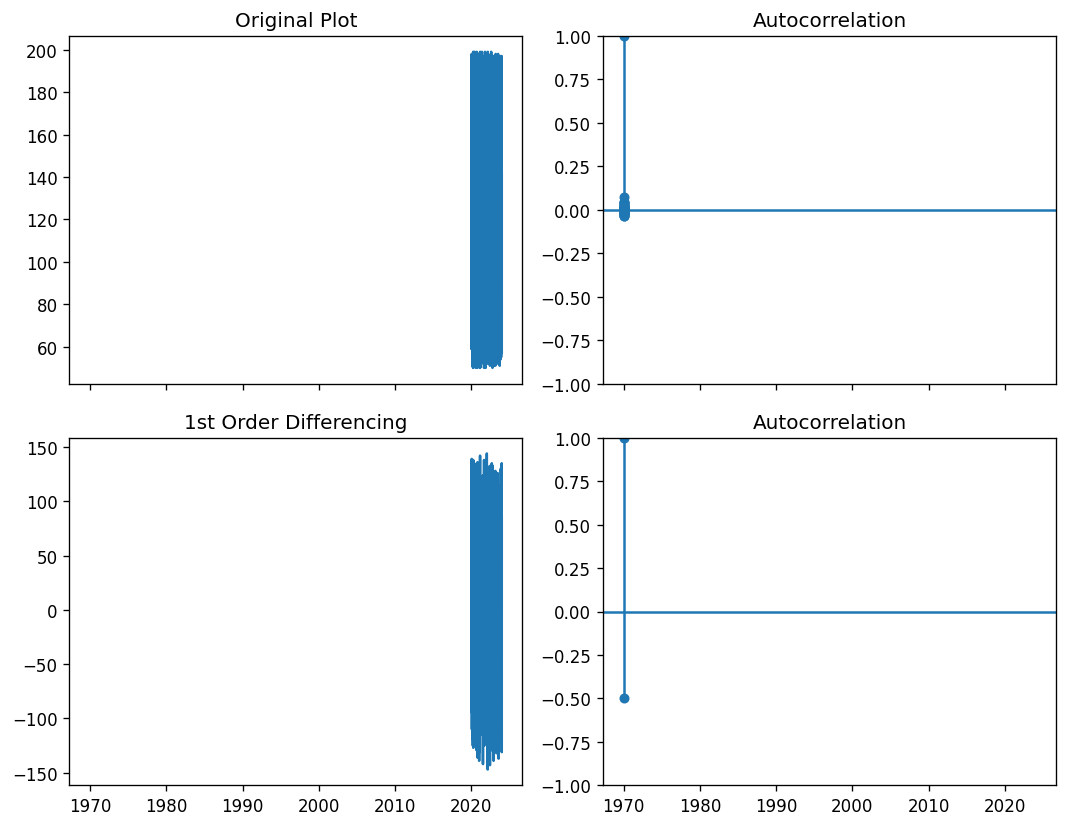

In [155]:
# Perform differencing if data requires further stabilizing
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 2, sharex=True)
axes[0, 0].plot(df['Query Rate'])
axes[0, 0].set_title('Original Plot')
plot_acf(df['Query Rate'], ax=axes[0, 1])

# 1st Differencing - in this case it doesn't matter

df_diff = df.diff().dropna()

axes[1, 0].plot(df_diff['Query Rate'])
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_diff['Query Rate'], ax=axes[1, 1], lags = 1)

plt.tight_layout()
plt.show()

## Split into Training & Testing Datasets

In [218]:
# Split dataset into training and testing sets (80% training, 20% testing)
trainingData_Size = int(len(df) * 0.8)
training, testing = df[:trainingData_Size], df[trainingData_Size:]
# testing, validation = temp[:testing_size], temp[testing_size:]

# Print sizes of training and testing sets
print("Training set size:", len(training))
print("Testing set size:", len(testing))

Training set size: 1168
Testing set size: 293


## Finding Optimal ARIMA Parameters

### Finding Optimal AR (p) term

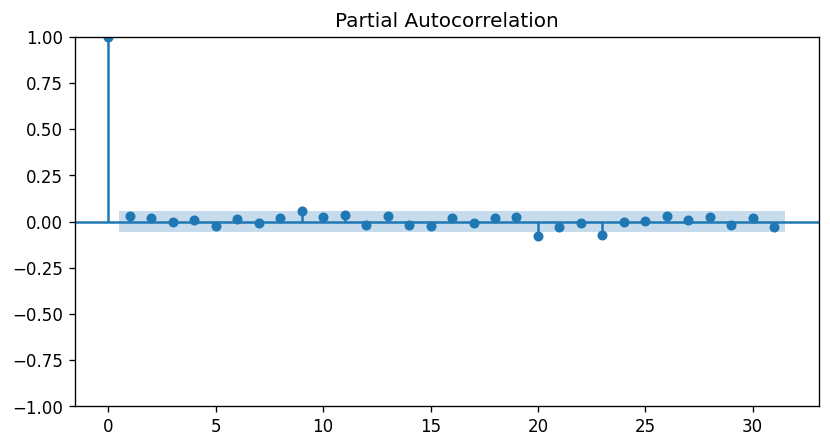

In [204]:
# Plot PACF to visually inspect lags
fig, axes = plt.subplots(figsize=(8, 4))
plot_pacf(training, ax=axes)
plt.show()

### Finding Optimal MA (q) term

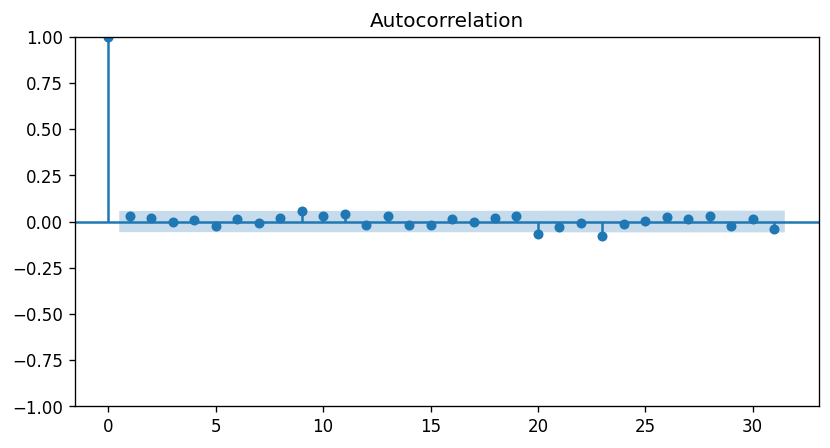

In [205]:
# Plot ACF to visually inspect lags
fig, axes = plt.subplots(figsize=(8, 4))
plot_acf(training, ax=axes)
plt.show()

## ARIMA Model

In [210]:
# Fit ARIMA model with optimal parameters
model = ARIMA(training['Query Rate'], order=(1,1,1))
fittedModel = model.fit()
print(fittedModel.summary())

/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Query Rate   No. Observations:                 1168
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6372.943
Date:                Sun, 12 May 2024   AIC                          12751.885
Time:                        13:20:04   BIC                          12767.072
Sample:                    01-02-2020   HQIC                         12757.614
                         - 03-14-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0307      0.030      1.024      0.306      -0.028       0.089
ma.L1         -0.9985      0.004   -248.301      0.000      -1.006      -0.991
sigma2      3226.6729    200.410     16.100      0.0

### Adjust Model Based on Results

In [213]:
# Adjust ARIMA model based on p values - here with fit without the AR term(0.306 > 0.05)
ar_removedModel = ARIMA(training['Query Rate'], order=(0,1,1))
ar_removedFitted = ar_removedModel.fit()
print("AR Removed Fitted Model:")
print()
print(ar_removedFitted.summary())

/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AR Removed Fitted Model:

                               SARIMAX Results                                
Dep. Variable:             Query Rate   No. Observations:                 1168
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6373.484
Date:                Sun, 12 May 2024   AIC                          12750.969
Time:                        13:21:57   BIC                          12761.093
Sample:                    01-02-2020   HQIC                         12754.788
                         - 03-14-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9958      0.003   -294.712      0.000      -1.002      -0.989
sigma2      3231.5032    199.042     16.235      0.000    2841.388    3621.618
Ljung-Box (L1) (Q):       

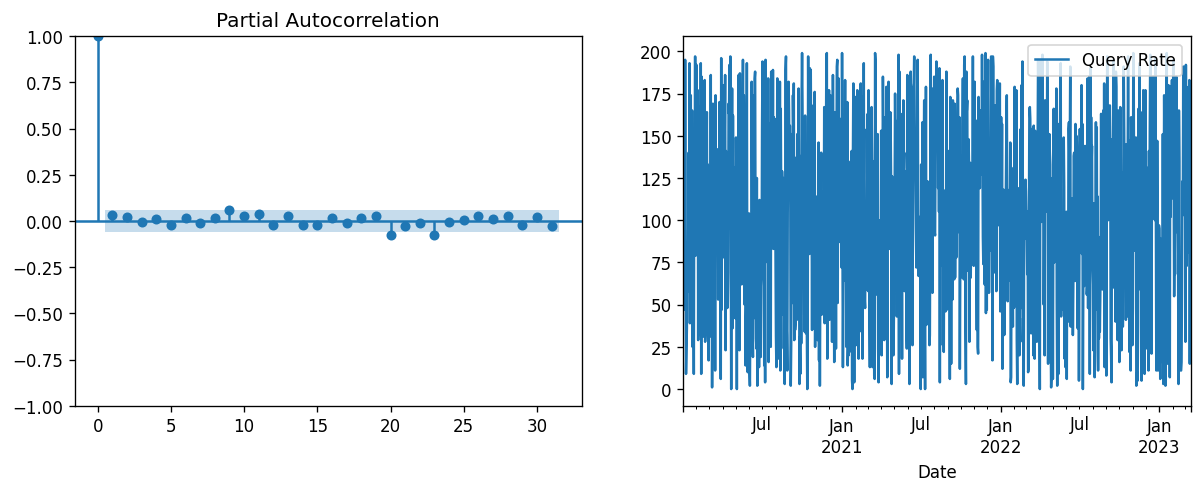

In [209]:
# Plot PACF and time series data side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_pacf(training, ax=axes[0])
training.plot(ax=axes[1])
plt.show()

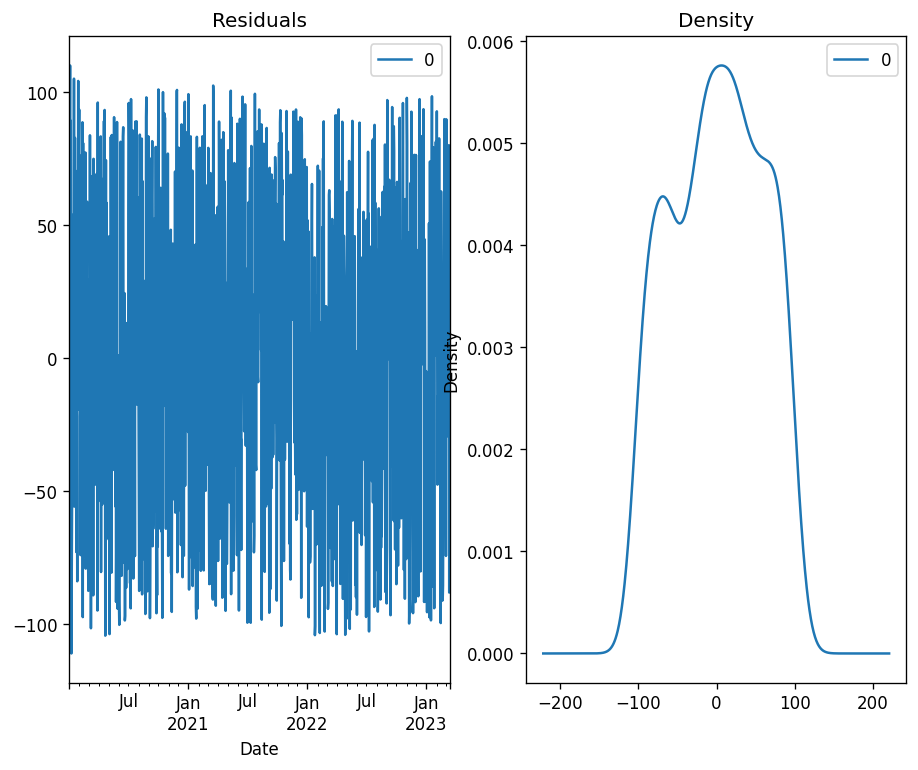

In [214]:
# Plot residual errors - check for stability
residuals = pd.DataFrame(ar_removedFitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## Evaluate Model Performance

In [249]:
predictions = list()
for i in range(len(testing)):
    output = ar_removedFitted.forecast()
    predictions.append(output[0])

#print(predictions[:10])
#print(predictions[-10:])

# Calculate evaluation metrics
mse = mean_squared_error(testing, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(testing, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 3462.6143626139014
Root Mean Squared Error (RMSE): 58.843983232051016
Mean Absolute Error (MAE): 51.515254105297416


To summarize, the following ARIMA skeleton follows the procedures of:
1. Importing Data
2. Data Preprocessing/Cleaning
3. Splitting Data into Training & Testing
4. Determining Optimal ARIMA Parameters
5. Fitting into ARIMA Training Dataset
6. Fine Tune Training Model
7. Evaluate Testing Model Performance

In this case, sufficient data wasn't gathered so an example dataset was randomly generated. However, the skeleton exemplifies a basic outline on common practices.